# **Final Project (section 5 - tumors)**

In [2]:
import os
import sys
import cv2 as cv
import numpy as np
import csv
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix

import importlib
from utils import Orb
from utils import siftKP

## 5.1 Preparing Data

Load Source Dataset (done locally)

In [3]:
np.set_printoptions(threshold=sys.maxsize)

In [4]:
path = '/content/drive/MyDrive/QC'
rgb_dir = os.path.join(path, "rgb")
mask_dir = os.path.join(path, "mask")
csv_dir = os.path.join(path, "csv")
split_path = os.path.join(path, 'split')

image_files = os.listdir(rgb_dir)
mask_files = os.listdir(mask_dir)
csv_files = os.listdir(csv_dir)

image_files.sort()
mask_files.sort()
csv_files.sort()

5.1.1  Convert Image and Masks to Grayscale

In [5]:
def loadGray(id):
    image_path = os.path.join(rgb_dir, id)
    image = cv.imread(image_path + '.png')
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #plt.imshow(mask, cmap = 'gray')

    mask_path = os.path.join(mask_dir, id)
    mask = cv.imread(mask_path + '.png')
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    #plt.imshow(mask, cmap = 'gray')


    return image, mask


5.1.2.  Multiply the Mask and the original to obtain regions of interest

In [6]:
def ROI(image, mask):
    # Ensure the mask and image are the same size
    min_height = min(image.shape[0], mask.shape[0])
    min_width = min(image.shape[1], mask.shape[1])

    image = image[:min_height, :min_width]
    mask = mask[:min_height, :min_width]

    # Threshold mask to find the actual ROI
    _, mask_binary = cv.threshold(mask, 1, 255, cv.THRESH_BINARY)  # Ensure binary mask (0 or 255)

    # Find contours of the mask to get the actual ROI bounding box
    contours, _ = cv.findContours(mask_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return np.zeros_like(image)  # Return an empty image if no mask is found

    # Get bounding box around the mask
    x, y, w, h = cv.boundingRect(contours[0])

    # Crop to the actual mask region
    mask_cropped = mask_binary[y:y+h, x:x+w]

    # Normalize and apply mask
    mask_cropped = mask_cropped.astype(np.float32) / 255.0  # Normalize mask

    # multiply cropped region of new mask with cropped mask
    newMask = 1-mask
    newMask[y:y+h, x:x+w] = newMask[y:y+h, x:x+w] * mask_cropped


    roi = newMask * image

    return roi


5.1.3. Remove background noice

In [7]:
def backgroundRemove(roi, mask):
    # Ensure the mask and roi are the same size
    min_height = min(roi.shape[0], mask.shape[0])
    min_width = min(roi.shape[1], mask.shape[1])

    roi = roi[:min_height, :min_width]
    mask = mask[:min_height, :min_width]

    _, binary_mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    result = np.where((roi != 0), roi * (1-binary_mask/255), 0)


    return result


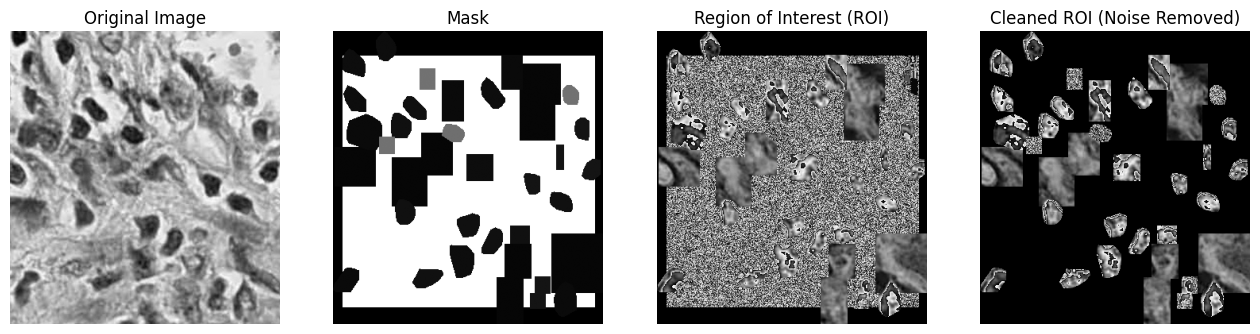

In [8]:
subject_id = "TCGA-A2-A0T0-DX1_id-5ea40989ddda5f839897f293_left-76950_top-61480_bottom-61778_right-77225"
image, mask = loadGray(subject_id)
roi = ROI(image,mask)
final = backgroundRemove(roi, mask)

# Display results
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Mask")
axs[1].axis("off")

axs[2].imshow(roi, cmap='gray')
axs[2].set_title("Region of Interest (ROI)")
axs[2].axis("off")

axs[3].imshow(final, cmap='gray')
axs[3].set_title("Cleaned ROI (Noise Removed)")
axs[3].axis("off")

plt.show()

Extract features

In [10]:
# get train, val patients
train_csv = os.path.join(split_path, 'train_subjects.csv')
val_csv = os.path.join(split_path, 'validate_subjects.csv')

def getPatients(csvPath):
    with open(csvPath, newline='') as csvfile:
        reader = csv.reader(csvfile)
        ids = list(reader)
    ids = ids[1:] # strip PatientID
    ids.sort()
    return ids

train_ids = getPatients(train_csv)
val_ids = getPatients(val_csv)

# get train, val image IDs
def getImages(ids):
    data = []
    for patient in ids:
        for filename in image_files:
            done = False
            if (filename.startswith(patient[0])):
                name = filename[:-4] # strip .png
                data.append(name)
                done = True
            elif (done):
                break # files are sorted
    return data

train_data = getImages(train_ids)
val_data = getImages(val_ids)

### SIFT and HoG

#### Extract Features and Define Labels

In [11]:
def Sift(train, test):
    '''
        Extract
        features from the input img.
        Variable:
            train(list): List of training data
            test(list): List of testing data
            key_or_desc(str): choosing to return keypoints or descriptors ('key', 'desc')
        Returns:
            train_sift_features(list): a list of all SIFT features from train data.
            test_sift_features(list): a list of all SIFT features from test data.
    '''
    ## Create SIFT Object and Compute Keypoints and Descriptors ##
    train_sift_key = {}
    train_sift_desc = {}
    test_sift_key = {}
    test_sift_desc = {}

    for idx, img in tqdm(enumerate(train)):
        sift = cv.SIFT_create()
        keypoints_t, descriptors_t = sift.detectAndCompute(img, None)
        if idx in train_sift_key:
            train_sift_key[idx].append(keypoints_t)
            train_sift_desc[idx].append(descriptors_t)
        else:
            train_sift_key[idx] = [keypoints_t]
            train_sift_desc[idx] = [descriptors_t]

    for img in tqdm(test):
        sift = cv.SIFT_create()
        keypoints_v, descriptors_v = sift.detectAndCompute(img, None)
        if idx in test_sift_key:
            test_sift_key.append(keypoints_v)
            test_sift_desc.append(descriptors_v)
        else:
            test_sift_key = [keypoints_v]
            test_sift_desc = [descriptors_v]

    return train_sift_key, train_sift_desc, test_sift_key, test_sift_desc


def HoG(train, test):
    '''
        Extract HoG features from the input img. Using L2 Normalization.
        Variable:
            train(list): List of training data
            test(list): List of testing data
        Returns:
            Returns:
            train_sift_features(list): a list of all Hog features from train data.
            test_sift_features(list): a list of all HoG features from test data.
    '''
    img_size = train[0].shape # h x w in pixels <- take a random image
    cell_size = (8, 8)
    block_size = (2, 2)
    nbins = 9  # number of orientation bins

    # create HoG Object
    hog = cv.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                     img_size[0] // cell_size[0] * cell_size[0]),
                           _blockSize=(block_size[1] * cell_size[1],
                                       block_size[0] * cell_size[0]),
                           _blockStride=(cell_size[1], cell_size[0]),
                           _cellSize=(cell_size[1], cell_size[0]),
                           _nbins=nbins,
                           _histogramNormType= cv.NORM_L2)

    train_hog_features = []
    test_hog_features = []
    ## Compute Features ##
    for img in tqdm(train):
        # Hog Features
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        try:
            temp = hog.compute(img.astype(np.uint8))
            train_hog_features.append(temp / np.linalg.norm(temp, ord=2)) # L2 Normalization
        except:
            train_hog_features.append(['o'])

    for img in tqdm(test):
        # Hog Features
        temp = hog.compute(img.astype(np.uint8))
        test_hog_features.append(temp / np.linalg.norm(temp, ord=2)) # L2 Normalization

    return train_hog_features, test_hog_features

In [12]:
# Get Train and test Images
def getData(ids):
    data = []
    for name in ids:
        for filename in image_files:
            if (filename.startswith(name)):
                img = cv.imread(os.path.join(rgb_dir, filename))
                data.append(img)
    return data

In [14]:
# ++++++++++++++++
# Extract Features
# ++++++++++++++++
train_dict = {'label': {}, 'coord': {}, 'data': []}
val_dict = {'label': {}, 'coord': {}, 'data': []}

# subject_id = "TCGA-A2-A0T0-DX1_id-5ea40989ddda5f839897f293_left-76950_top-61480_bottom-61778_right-77225"
# img1, _ = loadGray(subject_id)
# train_hog, val_hog = HoG([img1], [img1])

for idx, i in enumerate([os.path.join(split_path, 'train_subjects.csv'),
                         os.path.join(split_path, 'validate_subjects.csv')]):
    if idx == 0:
        current_dict = train_dict
        print("Now working on training data")
    else:
        current_dict = val_dict
        print("Now working on validation data")

    names = []
    print("reading csv file")
    with open(i) as f:
        reader = csv.reader(f)
        next(reader)
        for r in tqdm(reader):
            names.append(r[0])

    current_dict['data'] = getData(names)

    for n in tqdm(names):
        temp1 = {}
        temp2 = {}
        csv_name = None

        # Find matching CSV file
        for filename in image_files:
            if filename.startswith(n):
                csv_name = filename[:-4] + '.csv'
                break  # Found the match, exit loop

        if not csv_name:
            print(f"Warning: No CSV found for {n}")
            continue


        with open(os.path.join(csv_dir, csv_name)) as f:
            reader = csv.reader(f)
            next(reader)
            for r in reader:
                if n in temp1:
                    temp1[n].append(r[2])
                else:
                    temp1[n] = [r[2]]

                xcoords = (float(r[5]), float(r[7]))
                ycoords = (float(r[6]), float(r[8]))
                coords = (xcoords, ycoords)

                if n in temp2:
                    temp2[n].append(coords)
                else:
                    temp2[n] = [coords]

                # Update dictionaries
        current_dict['label'].update(temp1)
        current_dict['coord'].update(temp2)


Now working on training data
reading csv file


99it [00:00, 249991.63it/s]
100%|██████████| 99/99 [00:00<00:00, 264.66it/s]


Now working on validation data
reading csv file


25it [00:00, 36083.14it/s]
100%|██████████| 25/25 [00:00<00:00, 285.72it/s]


In [15]:
def extract_sift_features(images):
    """
    Extract SIFT features from a list of images

    Args:
        images (list): List of input images (numpy arrays)

    Returns:
        tuple: (keypoints, descriptors) where:
            - keypoints: List of cv2.KeyPoint arrays for each image
            - descriptors: List of descriptor arrays (n_features x 128)
    """
    sift = cv.SIFT_create()  # Create once and reuse
    keypoints = []
    descriptors = []

    for img in images:
        kp, desc = sift.detectAndCompute(img, None)
        keypoints.append(kp)
        descriptors.append(desc if desc is not None else np.array([]))  # Handle empty cases

    return keypoints, descriptors

def Sift(train, test):
    """
    Extract SIFT features from training and test sets

    Args:
        train (list): List of training images
        test (list): List of test images

    Returns:
        tuple: (train_kp, train_desc, test_kp, test_desc)
    """
    print("Extracting SIFT features for training set...")
    train_kp, train_desc = extract_sift_features(train)

    print("Extracting SIFT features for test set...")
    test_kp, test_desc = extract_sift_features(test)

    return train_kp, train_desc, test_kp, test_desc

In [16]:
print("Now making the dictionary")
train_sift_key, train_sift_desc, val_sift_key, val_sift_desc = Sift(train_dict['data'], val_dict['data'])
# train_hog, val_hog = HoG(train_dict['data'], val_dict['data'])


train_dict['sift'] = [train_sift_key, train_sift_desc]
# train_dict['hog'] = train_hog
val_dict['sift'] = [val_sift_key, val_sift_desc]
# val_dict['hog'] = val_hog

# Beware! This block runs for a long time due to feature extraction

Now making the dictionary
Extracting SIFT features for training set...
Extracting SIFT features for test set...


In [17]:
# Debug print to check structure
print(f"Number of images: {len(train_dict['sift'][0])}")
print(f"Keypoints for 3rd image: {len(train_dict['sift'][0][3])} keypoints")
print(f"First keypoint type: {type(train_dict['sift'][0][3][0])}")
print(f"First keypoint: {train_dict['sift'][0][3][0]}")
print(f"Descriptors shape: {len(train_dict['sift'][1][3])}")

Number of images: 1335
Keypoints for 3rd image: 2307 keypoints
First keypoint type: <class 'cv2.KeyPoint'>
First keypoint: < cv2.KeyPoint 0x7d8482e29e00>
Descriptors shape: 2307


In [18]:
# Debug print to check structure
print(f"Number of images: {len(val_dict['sift'][0])}")
print(f"Keypoints for 3rd image: {len(val_dict['sift'][0][3])} keypoints")
print(f"First keypoint type: {type(val_dict['sift'][0][3][0])}")
print(f"First keypoint: {val_dict['sift'][0][3][0]}")
print(f"Descriptors shape: {len(val_dict['sift'][1][3])}")

Number of images: 409
Keypoints for 3rd image: 2259 keypoints
First keypoint type: <class 'cv2.KeyPoint'>
First keypoint: < cv2.KeyPoint 0x7d84795b82a0>
Descriptors shape: 2259


In [19]:
# label sift descriptors from .csv file
train_features = []
train_labels = []
for kp in train_dict['sift'][0][idx]:
    # for i, img in tqdm(enumerate(train_dict['sift'][0][idx])): # get the key
    for idx, name in tqdm(zip(range(len(train_dict['label'].keys())), train_dict['label'].keys())):
        #print(kp)
        x, y = kp.pt
        found = False
        for j, coord in enumerate(train_dict['coord'][name]):
            (xmin, xmax), (ymin, ymax) = coord

            if xmin <= x <= xmax and ymin <= y <= ymax:
                label = train_dict['label'][name][j]
                found = True
                break
        if not found:
            label = 'background' # not identified in CSV
    train_features.append(train_dict['sift'][1][idx])
    train_labels.append(label)

# label sift descriptors from .csv file
val_features = []
val_labels = []
for kp in val_dict['sift'][0][idx]:
    # for i, img in tqdm(enumerate(train_dict['sift'][0][idx])): # get the key
    for idx, name in tqdm(zip(range(len(val_dict['label'].keys())), val_dict['label'].keys())):
        #print(kp)
        x, y = kp.pt
        found = False
        for j, coord in enumerate(val_dict['coord'][name]):
            (xmin, xmax), (ymin, ymax) = coord

            if xmin <= x <= xmax and ymin <= y <= ymax:
                label = val_dict['label'][name][j]
                found = True
                break
        if not found:
            label = 'background' # not identified in CSV
    val_features.append(val_dict['sift'][1][idx])
    val_labels.append(label)

99it [00:00, 32253.85it/s]
99it [00:00, 33858.13it/s]
99it [00:00, 32739.58it/s]
99it [00:00, 35532.78it/s]
99it [00:00, 37140.97it/s]
99it [00:00, 40267.27it/s]
99it [00:00, 29110.78it/s]
99it [00:00, 36536.39it/s]
99it [00:00, 36401.87it/s]
99it [00:00, 28429.15it/s]
99it [00:00, 31068.92it/s]
99it [00:00, 25336.27it/s]
99it [00:00, 40645.66it/s]
99it [00:00, 47105.63it/s]
99it [00:00, 35584.55it/s]
99it [00:00, 49426.98it/s]
99it [00:00, 33320.18it/s]
99it [00:00, 31882.38it/s]
99it [00:00, 32590.54it/s]
99it [00:00, 45331.45it/s]
99it [00:00, 38486.99it/s]
99it [00:00, 37598.34it/s]
99it [00:00, 36360.43it/s]
99it [00:00, 36101.21it/s]
99it [00:00, 21303.99it/s]
99it [00:00, 36762.82it/s]
99it [00:00, 38112.54it/s]
99it [00:00, 35243.26it/s]
99it [00:00, 35976.10it/s]
99it [00:00, 37180.88it/s]
99it [00:00, 38981.98it/s]
99it [00:00, 38302.38it/s]
99it [00:00, 36398.68it/s]
99it [00:00, 36536.39it/s]
99it [00:00, 23955.01it/s]
99it [00:00, 36120.05it/s]
99it [00:00, 35566.26it/s]
9

In [20]:
unique_labels = np.unique(train_labels)
print("Unique labels:", unique_labels)

label_mapping = {
    'tumor_mitotic': 'tumor',          # Mitotic tumor → tumor
    'tumor_nonMitotic': 'tumor',       # Non-mitotic tumor → tumor
    'nonTILnonMQ_stromal': 'non-tumor', # Stromal → non-tumor
    'background': 'non-tumor',         # Background → non-tumor
    'lymphocyte': 'non-tumor',
    'AMBIGUOUS': 'non-tumor'           # Ambiguous cases → non-tumor
}

labels_binary_train = np.array([label_mapping[label] for label in train_labels])
labels_binary_val = np.array([label_mapping[label] for label in val_labels])


Unique labels: ['background' 'tumor_nonMitotic']


In [21]:
train_X = np.vstack([np.squeeze(img_features) for img_features in train_features])
train_Y = np.hstack([np.full(len(np.squeeze(img_features)), label)
                    for img_features, label in zip(train_features, labels_binary_train)])

val_X = np.vstack([np.squeeze(img_features) for img_features in val_features])
val_Y = np.hstack([np.full(len(np.squeeze(img_features)), label)
                    for img_features, label in zip(val_features, labels_binary_val)])

### Orb

In [22]:
## EXTRACT AND CLASSIFY FEATURES ##
# get ROIs and labels for tumor/non tumor from csv
def labelsAndPixels(imageName):
    csvName = imageName + '.csv'
    labels = [] # blob label
    xyminmax = [] # blob coordinates in form: ((xmin, xmax), (ymin, ymax))

    csvPath = os.path.join(csv_dir, csvName)
    with open(csvPath, newline='') as f:
        reader = csv.reader(f)
        next(reader) # skip first row
        for row in reader:
            labels.append(row[1])
            # get min and max x and y coords for ROI
            xcoords = (float(row[5]), float(row[7]))
            ycoords = (float(row[6]), float(row[8]))
            coords = (xcoords, ycoords)

    return labels, coords

# extract features from image and classify
def featuresClassify(imageName, doSIFT=True, visualize=False):
    """"    Extracts ORB features from only the foreground image and get ground
            truth based on the blob labels in the .csv
            Takes as argument image id (no .png)
            Returns:
                imgLabels: list of all labels for descriptors
                imgFeatures: list of all feature descriptors """
    # preprocess image to remove background
    image, mask = loadGray(imageName)
    roi = ROI(image,mask)
    img = backgroundRemove(roi, mask)

    # normalize and convert to uint8 for cv2
    img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
    img = img.astype(np.uint8)
    # get mask to avoid getting keypoints at black bounds of ROI
    mask = (img != 0).astype(np.uint8) * 255

    # extract Orb features
    orbkp, features = Orb(img, mask, visualize)
    # extract SIFT features at Orb keypoints if doSIFT=True
    if(doSIFT):
        _, siftdes = siftKP(img, orbkp)
        # concatenate orb + sift
        features = np.hstack((features, siftdes))

    # plot keypoints
    if (visualize):

        img2 = cv.drawKeypoints(img, orbkp, None)
        plt.figure()
        plt.imshow(img2)

    # get labelled regions to classify features
    labels, coords = labelsAndPixels(imageName)

    # label orb descriptors from .csv file
    imgLabels = []
    imgFeatures = []
    for i, kp in enumerate(orbkp):
        x, y = kp.pt
        for j, jcoords in enumerate(coords):
            (xmin, xmax), (ymin, ymax) = coords

            # find the region the keypoint falls in
            found = False
            if xmin <= x <= xmax and ymin <= y <= ymax:
                label = labels[j]
                found = True
                break
        if (found == False):
            label = 'unlabeled' # not identified in CSV
        imgLabels.append(label)
        imgFeatures.append(features[i])

    return imgLabels, imgFeatures

Classify features, get train and test x and y sets

In [23]:
# extract and classify features for all images in dataset
def classifyData(data):
    print(f'Classifying data: {len(data)} Images.')
    setLabels = []
    setFeatures = []
    for name in data:
        l, f = featuresClassify(name)
        setLabels.extend(l)
        setFeatures.extend(f)
    print(f"{setLabels.count('tumor')} tumor features out of {len(setLabels)} features in the dataset")
    return setFeatures, setLabels

# classify train data
trainFeatures, trainLabels = classifyData(train_data)
xTrain = trainFeatures
yTrain = ['non_tumor' if label != 'tumor' else label for label in trainLabels]

# classify val data
valFeatures, valLabels = classifyData(val_data)
xVal = valFeatures
yVal = ['non_tumor' if label != 'tumor' else label for label in valLabels]

Classifying data: 1335 Images.
11920 tumor features out of 581754 features in the dataset
Classifying data: 409 Images.
4203 tumor features out of 170230 features in the dataset


5.2 Train the SVM with ROI

In [ ]:
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

def downsample(x, y, rate=0.05):

    x = np.array(x)
    y = np.array([1 if label == "tumor" else 0 for label in y])  # binarize

    assert x.shape[0] == y.shape[0], "Mismatch in number of samples"

    total_target = int(len(y) * rate)
    tumor_x = x[y == 1]
    nontumor_x = x[y == 0]

    if len(tumor_x) == 0 or len(nontumor_x) == 0:
        raise ValueError("One of the classes is empty")

    max_balanced = 2 * min(len(tumor_x), len(nontumor_x))
    total_target = min(total_target, max_balanced)
    samples_per_class = total_target // 2

    tumor_down = resample(tumor_x, replace=False, n_samples=samples_per_class, random_state=42)
    nontumor_down = resample(nontumor_x, replace=False, n_samples=samples_per_class, random_state=42)

    x_down = np.vstack([tumor_down, nontumor_down])
    y_down = np.array([1]*samples_per_class + [0]*samples_per_class)

    return x_down, y_down

xTrain_bal, yTrain_bal = downsample(xTrain, yTrain)


clf = SVC(kernel='rbf', probability=True, random_state=42)
clf.fit(xTrain_bal, yTrain_bal)

y_pred = clf.predict(xVal)
y_proba = clf.predict_proba(xVal)[:, 1]


yVal_bin = np.array([1 if label == "tumor" else 0 for label in yVal])

acc = accuracy_score(yVal_bin, y_pred)
print("Accuracy:", acc)

roc_auc = roc_auc_score(yVal_bin, y_proba)
print("ROC AUC:", roc_auc)

fpr, tpr, _ = roc_curve(yVal_bin, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


## Compute the RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def count_true_tumors(image_name):
    csv_path = os.path.join(csv_dir, image_name + ".csv")
    count = 0
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        for row in reader:
            if row[1] == "tumor":
                count += 1
    return count

def count_predicted_tumors(image_name):
    labels, features = featuresClassify(image_name)
    if len(features) == 0:
        return 0  # no blobs in this image

    features = np.array(features)
    preds = clf.predict(features)
    return np.sum(preds == 1)

# Loop over validation images
true_counts = []
pred_counts = []

for img_id in val_data:
    true_n = count_true_tumors(img_id)
    pred_n = count_predicted_tumors(img_id)

    true_counts.append(true_n)
    pred_counts.append(pred_n)

# Compute RMSE
rmse = sqrt(mean_squared_error(true_counts, pred_counts))
print("Tumor Count RMSE on Validation Set:", rmse)
